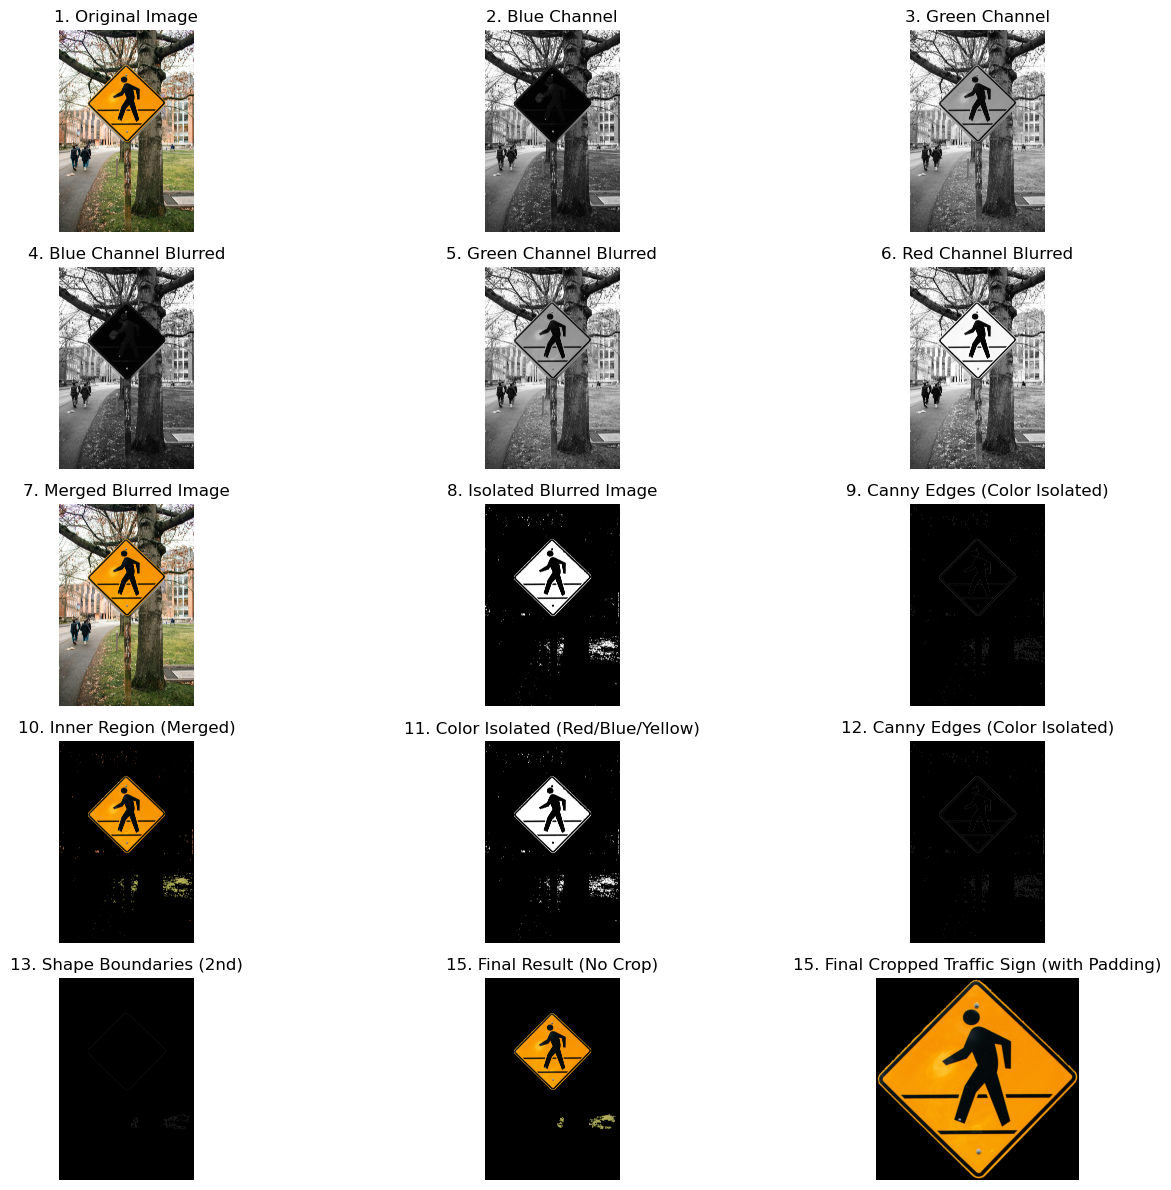

Pipeline Complete!
Original Image Shape: (4500, 3000, 3)
Final Result Shape: (4500, 3000, 3)
Cropped Region (with padding): x=624, y=766, w=1755, h=1745


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

# ============ Define all functions first ============

def gaussian_blur_canny(image, kernel_size=5, canny_low=50, canny_high=150):
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    blurred = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)
    edges = cv2.Canny(blurred, canny_low, canny_high)
    
    return edges

def isolate_traffic_sign_colors_strict(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # STRICT RED
    lower_red1 = np.array([0, 120, 100])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 120, 100])
    upper_red2 = np.array([180, 255, 255])
    
    # VERY STRICT DEEP BLUE
    lower_blue = np.array([110, 150, 100])
    upper_blue = np.array([120, 255, 220])
    
    # STRICT YELLOW
    lower_yellow = np.array([18, 120, 150])
    upper_yellow = np.array([32, 255, 255])
    
    mask_red1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask_red2 = cv2.inRange(hsv, lower_red2, upper_red2)
    mask_red = cv2.bitwise_or(mask_red1, mask_red2)
    
    mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
    
    combined_mask = cv2.bitwise_or(mask_red, mask_blue)
    combined_mask = cv2.bitwise_or(combined_mask, mask_yellow)
    
    kernel = np.ones((3, 3), np.uint8)
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, kernel, iterations=2)
    
    return combined_mask

def extract_inner_region(original_image, boundary_image):
    mask = boundary_image.copy()
    
    contours, _ = cv2.findContours(boundary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:
        cv2.fillPoly(mask, [contour], 255)
    
    mask_normalized = mask.astype(np.float32) / 255.0
    
    if len(original_image.shape) == 3:
        result = original_image.copy().astype(np.float32)
        for i in range(3):
            result[:, :, i] = result[:, :, i] * mask_normalized
        result = result.astype(np.uint8)
    else:
        result = (original_image.astype(np.float32) * mask_normalized).astype(np.uint8)
    
    return result, mask

def extract_shape_boundaries(image, kernel_size=5, min_area=100):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    result = np.zeros_like(image)
    
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > min_area:
            cv2.drawContours(result, [contour], -1, 255, 1)
    
    return result

def extract_inner_region_cropped(original_image, boundary_image, padding=15):
    inner_image, mask = extract_inner_region(original_image, boundary_image)
    contours, _ = cv2.findContours(boundary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) > 0:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        
        # Add padding to bounding box
        x_padded = max(0, x - padding)
        y_padded = max(0, y - padding)
        x2_padded = min(inner_image.shape[1], x + w + padding)
        y2_padded = min(inner_image.shape[0], y + h + padding)
        
        cropped = inner_image[y_padded:y2_padded, x_padded:x2_padded]
        return cropped, (x_padded, y_padded, x2_padded - x_padded, y2_padded - y_padded)
    
    return inner_image, None

# Load image
img = cv2.imread("train/test2.jpg", 1)

# Display original
plt.figure(figsize=(15, 12))
plt.subplot(5, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("1. Original Image")
plt.axis('off')

# ============ STEP 1: Split into 3 BGR channels ============
b_channel = img[:, :, 0]
g_channel = img[:, :, 1]
r_channel = img[:, :, 2]

plt.subplot(5, 3, 2)
plt.imshow(b_channel, cmap='gray')
plt.title("2. Blue Channel")
plt.axis('off')

plt.subplot(5, 3, 3)
plt.imshow(g_channel, cmap='gray')
plt.title("3. Green Channel")
plt.axis('off')

# ============ STEP 2: Apply Gaussian Blur on each channel ============
kernel_size = 5
b_blurred = cv2.GaussianBlur(b_channel, (kernel_size, kernel_size), 0)
g_blurred = cv2.GaussianBlur(g_channel, (kernel_size, kernel_size), 0)
r_blurred = cv2.GaussianBlur(r_channel, (kernel_size, kernel_size), 0)

plt.subplot(5, 3, 4)
plt.imshow(b_blurred, cmap='gray')
plt.title("4. Blue Channel Blurred")
plt.axis('off')

plt.subplot(5, 3, 5)
plt.imshow(g_blurred, cmap='gray')
plt.title("5. Green Channel Blurred")
plt.axis('off')

plt.subplot(5, 3, 6)
plt.imshow(r_blurred, cmap='gray')
plt.title("6. Red Channel Blurred")
plt.axis('off')

# ============ STEP 3: Merge channels back ============
merged = cv2.merge([b_blurred, g_blurred, r_blurred])

plt.subplot(5, 3, 7)
plt.imshow(cv2.cvtColor(merged, cv2.COLOR_BGR2RGB))
plt.title("7. Merged Blurred Image")
plt.axis('off')


color_isolated_first=isolate_traffic_sign_colors_strict(merged)
plt.subplot(5, 3, 8)
plt.imshow(cv2.cvtColor(color_isolated_first, cv2.COLOR_BGR2RGB))
plt.title("8. Isolated Blurred Image")
plt.axis('off')

# ============ STEP 4: Apply Canny on merged image ============
def gaussian_blur_canny(image, kernel_size=5, canny_low=50, canny_high=150):
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    blurred = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)
    edges = cv2.Canny(blurred, canny_low, canny_high)
    
    return edges

canny_step1 = gaussian_blur_canny(color_isolated_first, kernel_size=5, canny_low=50, canny_high=150)

plt.subplot(5, 3, 9)
plt.imshow(canny_step1, cmap='gray')
plt.title("9. Canny Edges (Color Isolated)")
plt.axis('off')

# ============ STEP 7: Extract Inner Region (directly from Canny) ============
inner_region_step1, mask_step1 = extract_inner_region(merged, canny_step1)

plt.subplot(5, 3, 10)
inner_rgb_step1 = cv2.cvtColor(inner_region_step1, cv2.COLOR_BGR2RGB)
plt.imshow(inner_rgb_step1)
plt.title("10. Inner Region (Merged)")
plt.axis('off')

# ============ STEP 8: Apply Color Isolation (2nd time) ============
def isolate_traffic_sign_colors_strict(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # STRICT RED
    lower_red1 = np.array([0, 120, 100])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 120, 100])
    upper_red2 = np.array([180, 255, 255])
    
    # VERY STRICT DEEP BLUE
    lower_blue = np.array([110, 150, 100])
    upper_blue = np.array([120, 255, 220])
    
    # STRICT YELLOW
    lower_yellow = np.array([18, 120, 150])
    upper_yellow = np.array([32, 255, 255])
    
    mask_red1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask_red2 = cv2.inRange(hsv, lower_red2, upper_red2)
    mask_red = cv2.bitwise_or(mask_red1, mask_red2)
    
    mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
    
    combined_mask = cv2.bitwise_or(mask_red, mask_blue)
    combined_mask = cv2.bitwise_or(combined_mask, mask_yellow)
    
    kernel = np.ones((3, 3), np.uint8)
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, kernel, iterations=2)
    
    return combined_mask

color_isolated = isolate_traffic_sign_colors_strict(inner_region_step1)

plt.subplot(5, 3, 11)
plt.imshow(color_isolated, cmap='gray')
plt.title("11. Color Isolated (Red/Blue/Yellow)")
plt.axis('off')

# ============ STEP 8: Apply Canny on Color Isolated Image ============
canny_step2 = gaussian_blur_canny(color_isolated, kernel_size=5, canny_low=30, canny_high=100)

plt.subplot(5, 3, 12)
plt.imshow(canny_step2, cmap='gray')
plt.title("12. Canny Edges (Color Isolated)")
plt.axis('off')

# ============ STEP 9: Extract Shape Boundaries (2nd time) ============
boundary_step2 = extract_shape_boundaries(canny_step2, min_area=5000)

plt.subplot(5, 3, 13)
plt.imshow(boundary_step2, cmap='gray')
plt.title("13. Shape Boundaries (2nd)")
plt.axis('off')

# ============ STEP 10: Extract Inner Region (2nd time) ============
inner_region_final, mask_final = extract_inner_region(inner_region_step1, boundary_step2)

plt.subplot(5, 3, 14)
plt.imshow(cv2.cvtColor(inner_region_final,cv2.COLOR_BGR2RGB))
plt.title("15. Final Result (No Crop)")
plt.axis('off')

cropped_result, bbox_info = extract_inner_region_cropped(inner_region_final, boundary_step2, padding=15)

plt.subplot(5, 3, 15)
if cropped_result is not None and cropped_result.size > 0:
    cropped_rgb = cv2.cvtColor(cropped_result, cv2.COLOR_BGR2RGB)
    plt.imshow(cropped_rgb)
    plt.title("15. Final Cropped Traffic Sign (with Padding)")
else:
    plt.imshow(inner_rgb_final)
    plt.title("15. Final Result (No Crop)")
plt.axis('off')

plt.tight_layout()
plt.show()

print("Pipeline Complete!")
print(f"Original Image Shape: {img.shape}")
print(f"Final Result Shape: {inner_region_final.shape}")
if bbox_info:
    print(f"Cropped Region (with padding): x={bbox_info[0]}, y={bbox_info[1]}, w={bbox_info[2]}, h={bbox_info[3]}")